In [83]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import pickle
import numpy as np
sys.path.append('../../../git/bva-capstone/nlp')

In [91]:
analysis_csv_path = '../../../data/bva/logs/roberta-idx-all-meta-f128-c256_checkpoint-49005_test_stats_latest.csv'
judge_emb_path = '../../../data/bva/checkpoints/roberta-idx-all-meta-f128-c256_checkpoint-49005-judge-emb_test_latest.npy'
vocab_path = '../../../data/bva/vocab/thresholded_vocab.pkl'
img_export_path = '../../../data/bva/images'

In [92]:
judge_embeddings = np.load(judge_emb_path)
list(judge_embeddings[0])

[-0.002472892, -0.030525075, 0.0017707502]

In [93]:
df = pd.read_csv(analysis_csv_path, delimiter=';')
min_year, max_year = min(df.year), max(df.year)
min_judge, max_judge = min(df.judge), max(df.judge)
years = list(range(min_year, max_year+1))
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [94]:
cit_class_dict = {}
for cit_id in range(0, len(vocab)):
    cl = vocab.citation_source_class_by_index(cit_id)
    if cl not in cit_class_dict:
        cit_class_dict[cl] = [cit_id]
    else:
        cit_class_dict[cl].append(cit_id)

In [95]:
def recall_at_k_in_year(df, k, year):
    dfx = df[(df['year'] == year) & (df['position'] < k)]
    total_df = df[df['year'] == year]
    return len(dfx) / len(total_df)


def recall_at_k_in_class(df, k, cl, year=None):
    dfx = df[(df['label'].isin(cit_class_dict[cl])) & (df['position'] < k)]
    total_df = df[df['label'].isin(cit_class_dict[cl])]
    if year:
        dfx = dfx[dfx['year'] == year]
        total_df = total_df[total_df['year'] == year]
    return len(dfx) / len(total_df)

def per_citation_recalls_at_k(df, k):
    rs = []
    num_uncited = 0
    for i in range(len(vocab)):
        dft = df[(df['label'] == i)]
        if len(dft) > 0:
            dfx = dft[dft['position'] < k]
            rs.append([i, len(dft), len(dfx) / len(dft)])
        else:
            num_uncited += 1
    return rs, num_uncited

def per_judge_recalls_at_k(df, k):
    rs = []
    num_no_opinions = 0
    for j in range(min_judge, max_judge+1):
        dft = df[(df['judge'] == j)]
        if len(dft) > 0:
            dfx = dft[dft['position'] < k]
            rs.append([j, len(dft), len(dfx) / len(dft), list(judge_embeddings[j])])
        else:
            num_no_opinions += 1
    return rs, num_no_opinions


In [96]:
recalls_at_1 = [recall_at_k_in_year(df, 1, y) for y in years]
recalls_at_5 = [recall_at_k_in_year(df, 5, y) for y in years]
recalls_at_20 = [recall_at_k_in_year(df, 20, y) for y in years]
plt.plot(years, recalls_at_20, label='k = 20')
plt.plot(years, recalls_at_5, label='k = 5')
plt.plot(years, recalls_at_1, label='k = 1')
plt.xticks(years, rotation='vertical')
plt.ylim(.3, 1.0)
plt.legend()
plt.title('RoBERTa c256->f128 Overall Recall @ k over Time')
plt.savefig(os.path.join(img_export_path, 'roberta_256_128_recall.pdf'))
plt.show()

In [97]:
k = 1
recall_at_1_case = [recall_at_k_in_class(df, k, 'case', year=y) for y in years]
recall_at_1_reg = [recall_at_k_in_class(df, k, 'reg', year=y) for y in years]
recall_at_1_code = [recall_at_k_in_class(df, k, 'code', year=y) for y in years]
plt.plot(years, recall_at_1_case, label='case')
plt.plot(years, recall_at_1_reg, label='regulation')
plt.plot(years, recall_at_1_code, label='statute')
plt.xticks(years, rotation='vertical')
plt.ylabel(f'citation recall @ {k}')
plt.xlabel(f'decision year')
plt.ylim(.0, 1.0)
plt.legend()
plt.savefig(os.path.join(img_export_path, 'roberta_256_128_per_class_recall_at_1.pdf'))
plt.show()

2063
2603


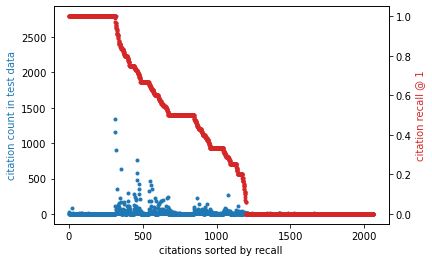

In [98]:
# sort by recall

%matplotlib inline
k = 1
per_cit_recalls, num_uncited = per_citation_recalls_at_k(df, k)
print(len(per_cit_recalls))
print(num_uncited)
cit_recalls_sorted = sorted(per_cit_recalls, key=lambda x: x[2], reverse=True)
cit_recalls = [r[2] for r in cit_recalls_sorted]
cit_counts = [r[1] for r in cit_recalls_sorted]
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(cit_counts, '.', color=color)
ax1.set_ylabel('citation count in test data', color=color)
ax1.set_xlabel('citations sorted by recall')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(cit_recalls, '.', color=color)
ax2.set_ylabel(f'citation recall @ {k}', color=color)
plt.savefig(os.path.join(img_export_path, 'roberta_256_128_recall_at_1_vs_count.pdf'))
plt.show()

293
72


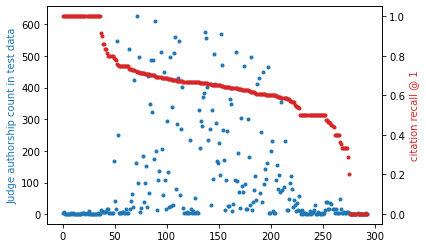

In [66]:
# sort by recall
%matplotlib inline
k = 1
per_j_recalls, num_no_opinions = per_judge_recalls_at_k(df, k)
print(len(per_j_recalls))
print(num_no_opinions)
j_recalls_sorted = sorted(per_j_recalls, key=lambda x: x[2], reverse=True)
j_recalls = [r[2] for r in j_recalls_sorted]
j_counts = [r[1] for r in j_recalls_sorted]
j_embs = [r[3] for r in j_recalls_sorted]
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(j_counts, '.', color=color)
ax1.set_ylabel('Judge authorship count in test data', color=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(j_recalls, '.', color=color)
ax2.set_ylabel(f'citation recall @ {k}', color=color)
plt.show()

In [82]:
%matplotlib qt 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [e[0] for e in j_embs]
y = [e[1] for e in j_embs]
z = [e[2] for e in j_embs]

ax.scatter(x, y, z, c=j_recalls, cmap='cool', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [81]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update)

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [16]:
import ipywidgets as widgets
from IPython.display import display
w = widgets.IntSlider()
display(w)

IntSlider(value=0)